#Case Study 1: Superconductors
##Team DEAN:
###**D**avid Wei | **E**dward Roske | **A**dam Canton | **N**eil Benson

##Team Goal:  
To create a linear regression model to answer:
- Can we make a formula to determine at what *critical_temp* will materials become superconductors?
- Which variables carry the most importance?  

##Introduction
We were presented with two large files with extensive data on various materials. Of the greatest importance was at what temperature these materials became superconductors (when those materials could transmit electricity with no resistance). We needed to join these files together and run a linear regression model to get weights (relative importances) for each of our many, many attributes.  
  
##Modeling  
Our group of data science professionals here at Team DEAN didn't just make a simple linear regression model, we also developed more complicated models using techniques like Lasso (Least Absolute Shrinkage and Selection Operator) and Ridge regression to make sure we weren't overfitting to our dataset.  

We also ran PCA (Principle Component Analysis) to see if we could reasonably reduce our large number of attributes down to a more easily digestible set of attributes. As is noted in the details below, we found that just 3 of our attributes contributed to over 32% of the variation in our model.

We optimized the hyperparameters for both Lasso and Ridge Regression. This was critical to finding the best possible models without overfitting.

That said, our final model ended up using simple Linear Regression because our stated goal was to create an accurate formula for determining critical temperatures. The most accurate formula was found by using all of the data in simple Linear Regression. If this model is determined to have too much bias as additional materials are tested, then the less-biased Lasso and Ridge models are contained below as well.

##Conclusion
We strongly advise skipping all the gory details found on the next several pages and jumping to the end of this report (to the section titled "Conclusion"). The majority of the next few pages are certainly interesting to the right audience, but they're not critical to answering the questions at hand.
  
***
    
Note: some portions of the notebook may have repurposed/reused code/text from prior case studies.  

#Setup

## Performance Optimization

If running into RAM issues while running on the hosted runtime, run locally using the following command (from anaconda prompt):

`pip install --upgrade jupyter_http_over_ws`

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0`

## Package Loading

In [ ]:
# SKLearn
import sklearn
from sklearn import datasets, tree, neighbors, decomposition, datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Other Packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
from pandas_profiling import ProfileReport
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

#Data Preparation    
We had two files to load. They had the same number of rows, but they needed to be combined, so we merged the data into a single dataset.

In [ ]:
#@title Data Loading
# Data loading
df1 = pd.read_csv("https://raw.githubusercontent.com/bensonnd/msds/ds7333-neil/ds7333/case_study_1/Data/train.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/bensonnd/msds/ds7333-neil/ds7333/case_study_1/Data/unique_m.csv")

# Change data types
#df1['number_of_elements'] = pd.to_numeric(df1['number_of_elements']).astype(int)

# Merge dataframes
df = pd.concat([df1.reset_index(drop=True), df2], axis=1)

# Drop unneeded variables - will remove this after EDA
#df = df.drop('material', axis=1) 

# print out some sample records
print(df.head(1))

   number_of_elements  mean_atomic_mass  ...  critical_temp         material
0                   4         88.944468  ...           29.0  Ba0.2La1.8Cu1O4

[1 rows x 170 columns]


# **Data Cleaning**

While testing for any duplicate columns (after merging the 2 files together), we saw that most of the columns were unique other than the last index being 'critical_temp' which contained a duplicate (from merging the data set).

In [ ]:
df.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

We noticed that since both filesets contained our response value *critical_temp*, we first tested if all records from the merged dataframe were equal and if they were, we will drop one of the duplicate response columns.

In [ ]:
if df1['critical_temp'].equals(df2['critical_temp']) == True:
    print('# of columns BEFORE duplicates:' +str(len(df.columns)))
    print('same column values, removing one')
    df = df.loc[:,~df.columns.duplicated()]
    print('# of columns AFTER duplicates:' +str(len(df.columns)))

# of columns BEFORE duplicates:170
same column values, removing one
# of columns AFTER duplicates:169


# **Exploratory Data Analysis**


Our data appeared to have no missing values. This was stated by the requesters of the study, and while we trusted them, it never hurts to verify. In the table below, all of the counts were 21,263, the number of records in our data set.

In [ ]:
# Output DataFrame columns & types
df.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,21263.0,21263.0
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,41.448045,769.614748,870.442317,737.474751,832.769649,1.299172,0.926726,572.222612,483.517264,215.631279,224.050033,157.983101,134.720039,144.448738,120.989330,1.267756,1.131138,139.325025,51.369885,51.601267,52.340465,6111.465214,5267.188547,3460.692235,3117.241110,1.072425,0.856037,8665.438818,2902.736814,3416.910784,...,0.007834,0.009152,0.049468,0.120994,0.101269,0.040491,0.004744,0.0,0.004129,0.568440,0.264953,0.030662,0.041494,0.039666,0.0,0.021992,0.017821,0.023959,0.002857,0.009536,0.008832,0.014217,0.008909,0.012716,0.026849,0.009168,0.036086,0.010424,0.038206,0.022512,0.061558,0.034108,0.020535,0.036663,0.047954,0.042461,0.201009,0.0,0.0,0.0
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,19.983544,87.488694,143.278200,78.327275,119.772520,0.381935,0.334018,309.614442,224.042874,109.966774,127.927104,20.147288,28.801567,22.090958,35.837843,0.375411,0.407159,67.272228,35.019356,22.898396,25.294524,2846.785185,3221.314506,3703.256370,3975.122587,0.342356,0.319761,4097.126831,2398.471020,1673.624915,...,0.167831,0.688729,0.521820,1.886951,1.839020,0.718043,0.088480,0.0,0.077676,0.983288,2.320822,0.173147,1.282059,0.224657,0.0,0.183173,0.151433,0.155860,0.064737,0.104153,0.098728,0.131417,0.130455,0.214806,0.276861,0.208969,0.851380,0.164628,1.177476,0.282265,0.864859,0.307888,0.717975,0.205846,0.272298,0.274365,0.655927,0.0,0.0,0.0
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,375.500000,375.500000,375.500000,375.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,48.000000,48.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.429000,1.429000,1.429000,0.686245,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [ ]:
print(df['material'].nunique())
print('='*80)
print(len(df))
print('='*80)
dcf = df.groupby(['material'],as_index=False).count()
#top 20 materials
print(dcf[['material', 'C']].nlargest(20,'C'))

15542
21263
                material    C
14964         Y1Ba2Cu3O7  110
2338      Bi2Sr2Ca1Cu2O8   80
7137   La1.85Sr0.15Cu1O4   51
458                B2Mg1   46
12904        Tl2Ba2Cu1O6   45
2336       Bi2Sr2Ca1Cu2O   44
14857          Y1Ba2Cu3O   44
14991         Y1Ba2Cu4O8   40
9957   Nd1.85Ce0.15Cu1O4   32
7287     La1.8Sr0.2Cu1O4   29
5631         Hg1Ba2Cu1O4   28
10043        Nd1Ba2Cu3O7   28
10874  Pr1.85Ce0.15Cu1O4   27
4958         Gd1Ba2Cu3O7   25
12177           Sr2Ru1O4   25
7381     La1.9Sr0.1Cu1O4   24
14945       Y1Ba2Cu3O6.9   23
2625                  C1   22
5580      Hg1Ba2Ca2Cu3O8   21
9327              Nb1Se2   21


From a quick summary of our data types and values. We observed that most of our data was made up of continouous attributes, excluding the material type. We saw that for material type specifically, there were 15,542 unique types of materials out of 21,263 total records which equated to 75% of the data being unique materials. We could have one-hot encoded this field, but it would have generated a various sparse set of over 15,000 attributes. As such, we removed the material attribute due to the large diverse independence of its attribute values.

Statistically summarizing the data, we saw that the elements (ex. 'Ir', 'Pt', 'Au', etc.) all had standard deviations less than 1 and had roughly the same mean. The lack of variation for these attributes could have allowed us to use our **domain knowledge** to simply remove them, but we left them in to see if our feature reduction techiniques (PCA, LDA) could also pick up on that trend.

In [ ]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 169 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie     

We next tested the validity of our response value *critical_temp* and its distribution. We saw that the distribution of our data was **right-skewed** where most of our *critical_temp* values were at or near 0 and then descended towards 50 before beginning to rise again. This skew definitely impacted our analysis, but it reflected analysis to-date in the field of superconductors: materials only become superconductors at *extremely* cold temperatures.  
  
On a good note, no critical_temp was below 0 which meant that our data was almost definitely in Kelvin. This was important to the analysis since on the Kelvin scale, a temperature of 2 is actually twice "as hot" as a temperature of 1. This is not true for Celsius or Fahrenheit. As such, we left our temperature "as is" (measured in degrees Kelvin) and just scaled our input attributes.

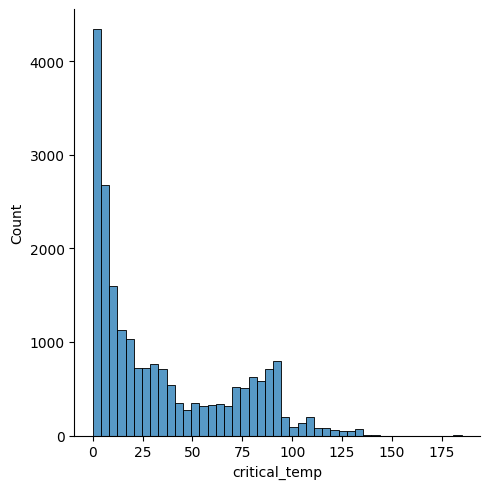

In [ ]:
sns.displot(df, x="critical_temp")

For a more complete exploration of our data, we could have, for instance, generated a Pandas Profiling report, but since our goal was to simply to use linear regression to determine the relationship between our various attributes and *critical_temp*, we omitted further EDA for now.

# **Feature Importance using PCA**

Considering our joined data set contained 160+ attributes, there was a high possibility of collinearity given that some of the attributes had similar values. We identified this during the EDA process as well. To trim down our regression variables, we ran PCA (Principal Component Analysis) to reduce the dimensionality of our dataset by using lower-order principle component weights as metrics of each individual attribute's significance compared to all the others.  
  
Note that the various attributes all had different scales so we normalized the data using a Standard Scaler to make them directly comparable.

In [ ]:
#creating temp df that stores all explanatory variables
expl = df.drop(['critical_temp', 'material'], axis=1)
# Standardize the feature
df_scaled= StandardScaler().fit_transform(expl)
n = 3
pca = PCA(n_components=n)
df_num_pca = pca.fit(df_scaled).transform(df_scaled)

pca.explained_variance_ratio_
Sum = sum(pca.explained_variance_ratio_) 
print(pca.explained_variance_ratio_)
print(Sum*100)
print('first', n , 'components explains', round(Sum*100), 'percentage of the variation')

[0.20844765 0.0580478  0.05366213]
32.01575780954504
first 3 components explains 32 percentage of the variation


It was clear from the chart below that the first 10 or so of the attributes resulted in over 50% of the variation. It was also clear that a plateau was reached around 90 attributes where additional attributes provided very little additional accuracy. In a later section, we have called out these "top 10" attributes.

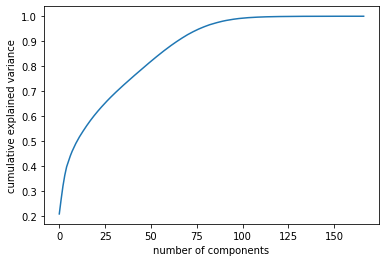

In [ ]:
pca_plot = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
df_col_names = list(expl.columns)

def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array

# assign weights with features
pca_weight_strings = get_feature_names_from_weights(pca.components_, df_col_names)

# extracting only the 1st component
pca_weight_comp1 = pca_weight_strings[0].split(' ')
print('PCA Component 1: '+str(pca_weight_comp1))

PCA Component 1: ['-0.15*number_of_ele', '+0.05*mean_atomic', '+0.10*wtd_mean_atomic', '+0.08*gmean_atomic', '+0.12*wtd_gmean_atomic', '-0.14*entropy_atomic', '-0.15*wtd_entropy_atomic', '-0.12*range_atomic', '+0.09*wtd_range_atomic', '-0.10*std_atomic', '-0.11*wtd_std_atomic', '-0.05*mea', '-0.13*wtd_mea', '-0.02*gmea', '-0.12*wtd_gmea', '-0.15*entrop', '-0.11*wtd_entrop', '-0.16*rang', '-0.08*wtd_rang', '-0.15*st', '-0.16*wtd_st', '+0.02*mean_atomic_r', '+0.12*wtd_mean_atomic_r', '+0.07*gmean_atomic_r', '+0.13*wtd_gmean_atomic_r', '-0.15*entropy_atomic_r', '-0.16*wtd_entropy_atomic_r', '-0.16*range_atomic_r', '+0.10*wtd_range_atomic_r', '-0.15*std_atomic_r', '-0.16*wtd_std_atomic_r', '+0.11*mean_De', '+0.13*wtd_mean_De', '+0.15*gmean_De', '+0.15*wtd_gmean_De', '-0.12*entropy_De', '-0.11*wtd_entropy_De', '-0.07*range_De', '+0.09*wtd_range_De', '-0.04*std_De', '-0.07*wtd_std_De', '+0.01*mean_ElectronAff', '-0.06*wtd_mean_ElectronAff', '+0.06*gmean_ElectronAff', '-0.01*wtd_gmean_Electro

Once we got the first component of PCA isolated into its own list, we cleaned up each element by removing it's sign-value (+, -) and then split it into its weight and name. Once complete, we converted the output into a dataframe to sort for further review and analysis.

In [ ]:
def conv_pca_df(self):
  cleaned_pca = []
  # removing the signs for the weights and using only the weight itself as a measurement of attribute significance
  for i in pca_weight_comp1:
      temp = str(i)
      if '-' in i:
          x = temp.replace('-', '').split('*')
          cleaned_pca.append(x)
      elif '+' in i:
          x = temp.replace('+', '').split('*')
          cleaned_pca.append(x)
  # convert nested array to df
  z = pd.DataFrame(cleaned_pca, columns=('Weight', 'Attribute'))
  z['Weight'] = pd.to_numeric(z['Weight'])
  return z

We observed that a good chunk of our principle component attributes had weights < 0.05. To reduce the dataset, we only included attributes with weights greater than 0.05. This trimmed down our component values by nearly 60%.

In [ ]:
conv_pca_df(pca_weight_comp1)

,Weight,Attribute
0,0.15,number_of_ele
1,0.05,mean_atomic
2,0.10,wtd_mean_atomic
3,0.08,gmean_atomic
4,0.12,wtd_gmean_atomic
...,...,...
162,0.00,
163,0.03,
164,0.00,
165,0.00,


In [ ]:
pca_result = conv_pca_df(pca_weight_comp1)
pca_result_reduced = pca_result[pca_result.Weight > .05]
print('# of attributes in PCA (total): '+str(len(pca_weight_comp1)))
print('='*80)
print('# of attributes with weight > .05: '+str(len(pca_result_reduced)))
print('='*80)
print(pca_result_reduced)

# of attributes in PCA (total): 168
# of attributes with weight > .05: 68
     Weight         Attribute
0      0.15     number_of_ele
2      0.10   wtd_mean_atomic
3      0.08      gmean_atomic
4      0.12  wtd_gmean_atomic
5      0.14    entropy_atomic
..      ...               ...
78     0.11      wtd_range_Va
88     0.12                  
109    0.09                  
118    0.06                  
136    0.08                  

[68 rows x 2 columns]


In [ ]:
intersection_cols = pca_result_reduced.columns & df.columns
res = df1[intersection_cols]
print(df1.columns)

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

These attributes listed above were the attributes with weights greater than 0.05. We are sure that list of top attributes must be fascinating to a Superconductor Scientist.

# Hyperparameter Tuning for L1 (Lasso) and L2 (Ridge)

We created models (as mentioned earlier) for Lasso and Ridge Regression. We also tuned those models using a grid search for the best possible RMSE (Root Mean Squared Error). We originally used an 80/20 train/test split, but later switched to using 3-fold cross-validation to utilize more of our data giving us more information for our algorithm.

In [ ]:
#@title Train/Test Split
#Train & Test Splits - 80/20
target_column = ['critical_temp'] 
material_column = ['material']
# removed the materials column as well
predictors = list(set(list(df.columns))-set(target_column) - set(material_column))
X = df[predictors].values
y = df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Scaled Data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

print(X_train.shape); print(X_test.shape)

(17010, 167)
(4253, 167)


In [ ]:
# X = df_num_pca
# y = df['critical_temp']

# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.20, random_state=42)
# X_train_pca.shape, y_train_pca.shape

In [ ]:
from sklearn.model_selection import KFold
# Create cross validation object - raise splits to 3-5, testing with 2
# should be fine with KFold since all columns and target are continuous
nj = -1
cv_reg = KFold(n_splits=3)

In [ ]:
%%time
from sklearn import linear_model

# intialize base L1 - Lasso - Regression Model
L1_Lasso_reg = linear_model.Lasso(random_state=42, max_iter=1500)

# setting the parameters
grid_L1 = {}
grid_L1['alpha'] = [.001, .01, .1, 1, 5, 10, 100, 1000]


L1_tuned = GridSearchCV(estimator=L1_Lasso_reg, param_grid=grid_L1, cv=cv_reg,
                        scoring='neg_root_mean_squared_error', n_jobs=nj, verbose=1)

L1_tuned.fit(X_train, y_train)


# summarize results
print("Mean RMSE: %.3f" % L1_tuned.best_score_)
print("Config RMSE: %s" % L1_tuned.best_params_)
print(f"Best estimator: {L1_tuned.best_estimator_}\n")


# setting the best paramaters for L1
L1_Lasso_reg = L1_tuned.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   21.6s finished


Mean RMSE: -19.185
Config RMSE: {'alpha': 1}
Best estimator: Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1500, normalize=False,
      positive=False, precompute=False, random_state=42, selection='cyclic',
      tol=0.0001, warm_start=False)

CPU times: user 700 ms, sys: 147 ms, total: 847 ms
Wall time: 22 s


In [ ]:
%%time

# intialize base L2 - Ridge - Regression Model
L2_ridge_reg = linear_model.Ridge(random_state=42)

# setting the parameters
grid_L2 = {}
grid_L2['alpha'] = [.001, .01, .1, 1, 5, 10, 100, 1000]
grid_L2['solver'] = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'auto', 'saga']

L2_tuned = GridSearchCV(estimator=L2_ridge_reg, param_grid=grid_L2, cv=cv_reg,
                        scoring='neg_root_mean_squared_error', n_jobs=nj, verbose=1)

L2_tuned.fit(X_train, y_train)


# summarize results
print("Mean RMSE: %.3f" % L2_tuned.best_score_)
print("Config RMSE: %s" % L2_tuned.best_params_)
print(f"Best estimator: {L2_tuned.best_estimator_}\n")


# setting the best paramaters for L2
L2_ridge_reg = L2_tuned.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  3.6min finished


Mean RMSE: -18.031
Config RMSE: {'alpha': 1000, 'solver': 'lsqr'}
Best estimator: Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='lsqr', tol=0.001)

CPU times: user 1.71 s, sys: 242 ms, total: 1.96 s
Wall time: 3min 37s


## Feature Importance Lasso and Ridge

We felt it would be helpful for our scientist audience to know the 10 most important attributes for predicting the temperature at which a material becomes a superconductor. We determined this list using both Lasso and Ridge.

<BarContainer object of 10 artists>

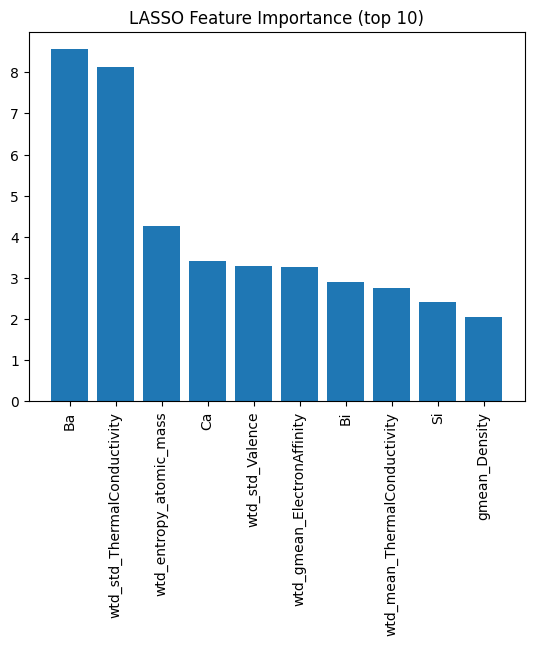

In [ ]:
# Fit best estimator model
L1_Lasso_reg.fit(X_train, y_train.ravel())

# Get feature importance and names
importance_L1 = np.abs(L1_Lasso_reg.coef_)
feature_names = np.array(predictors)

# getting it to the top 10 features,  note we are using abs(coef)
pre_importance = {'Imp':importance_L1, 'Feature':feature_names}
L1_importance = pd.DataFrame(pre_importance)
L1_importance_Df = L1_importance
L1_importance.sort_values(by = 'Imp', ascending=False, inplace=True)
L1_importance_plot = L1_importance.head(10)

# Plot top 10 features
plt.title("LASSO Feature Importance (top 10)")
plt.xticks(rotation = 90, fontsize = 10)
plt.bar(height=L1_importance_plot['Imp'], x=L1_importance_plot['Feature'])

For Lasso Regression, two attributes really stood out in their feature importance: **Ba** (does the material contain the element Barium) and **wtd_std_ThermalConductivity** (a weighted and standardized measure of a material's natural thermal conductivity). Interestingly, two other elements, when present, dramatically impact a materials superconducting temperature: Ca (Calcium), Bi (Bismuth), and Si (Silicon).

<BarContainer object of 10 artists>

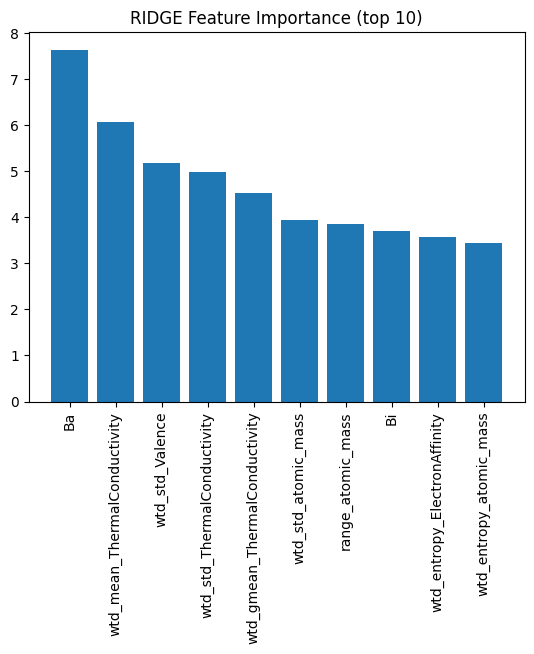

In [ ]:
# Fit best estimator model
L2_ridge_reg.fit(X_train, y_train)

# Get feature importance and names
importance_L2 = np.abs(L2_ridge_reg.coef_)
feature_names = np.array(predictors)

# getting it to the top 10 features,  note we are using abs(coef)
pre_importance = {'Imp':importance_L2.ravel(), 'Feature':feature_names}
L2_importance = pd.DataFrame(pre_importance)
L2_importance_Df = L2_importance
L2_importance.sort_values(by = 'Imp', ascending=False, inplace=True)
L2_importance_plot = L2_importance.head(10)

# Plot top 10 features
plt.title("RIDGE Feature Importance (top 10)")
plt.xticks(rotation = 90, fontsize = 10)
plt.bar(height=L2_importance_plot['Imp'], x=L2_importance_plot['Feature'])

For Ridge Regression, the top two attributes were similar (though not as impactful) to the top two in Lasso Regression: **Ba** (does the material contain the element Barium) and **wtd_*mean*_ThermalConductivity** (a weighted - *but unlike Lasso, not standardized* - measure of a material's natural thermal conductivity). Interestingly, the list diverged somewhat after that. For instance in Ridge, the only other element appearing in the top 10 was Bi (Bismuth) which also appeared in the Lasso model.  

In [ ]:
# Lasso CV Scores
RMSE_L1 = cross_val_score(L1_Lasso_reg, X_train, y_train.ravel(),cv=cv_reg, scoring = 'neg_root_mean_squared_error')
r_sq_L1 = cross_val_score(L1_Lasso_reg, X_train, y_train.ravel(),cv=cv_reg, scoring = 'r2')

# Ridge CV Scores
RMSE_L2 = cross_val_score(L2_ridge_reg, X_train, y_train.ravel(),cv=cv_reg, scoring = 'neg_root_mean_squared_error')
r_sq_L2 = cross_val_score(L2_ridge_reg, X_train, y_train.ravel(),cv=cv_reg, scoring = 'r2')


print(f' Mean Lasso RMSE: {round(np.abs(RMSE_L1.mean()),4)}, Mean Lasso R2: {round(r_sq_L1.mean(),4)}')
print('-'*80)
print(f' Mean Ridge RMSE: {round(np.abs(RMSE_L2.mean()),4)}, Mean Ridge R2: {round(r_sq_L2.mean(),4)}')

 Mean Lasso RMSE: 19.185, Mean Lasso R2: 0.6876
--------------------------------------------------------------------------------
 Mean Ridge RMSE: 18.0313, Mean Ridge R2: 0.724


In [ ]:
ypred_L1 = L1_Lasso_reg.predict(X_test)
ypred_L2 = L2_ridge_reg.predict(X_test)

print('Mean squared error L1:', round(np.sqrt(mean_squared_error(y_test, ypred_L1)),4))
print('Coefficient of determination:', round(r2_score(y_test, ypred_L1),4))
print('-'*80)
print('Mean squared error L2:', round(np.sqrt(mean_squared_error(y_test, ypred_L2)),4))
print('Coefficient of determination:', round(r2_score(y_test, ypred_L2),4))

Mean squared error L1: 18.2197
Coefficient of determination: 0.7116
--------------------------------------------------------------------------------
Mean squared error L2: 17.0013
Coefficient of determination: 0.7489


Of these two models (Lasso and Ridge), Ridge had not only the lower RMSE, it also had the higher percentage of the variation in critical temperatures explained by the model itself.  

However, as we stated at the beginning, for the highest accuracy using the most data, we turned to Linear Regression.

#Linear Regression     
We had over 20,000 rows of data and 168 variables to predict the target (critical_temp) and our goal was not to optimize our RMSE. Our goal was to find an accurate model that predicted the temperature at which a material became a superconductor, so we used multiple linear regression as our final method.

In [ ]:
#@title Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)  # x=input, y=target

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Once we created our model, we wanted to determine the relative weight/importance of each of our variables. This list of weights is lengthy (there are 168 variables, after all) but listed below for completeness:

In [ ]:
#@title Variable Importance
print('intercept:', lr.intercept_)
print('Coefficients: \n', lr.coef_)                  # get the slope values

intercept: [-4.4076348 -4.4076348]
Coefficients: 
 [[-5.10644617e+00  4.98590874e+00 -5.25576369e-01 -4.16694390e-01
   7.93528700e+00  7.49003469e-01 -7.20738565e+01 -6.56055828e-02
   9.08039681e-01  7.88889804e+00 -3.84640151e+01 -2.93997744e-01
   8.41300973e-02 -1.47786903e-01 -1.35291859e+00 -1.27294740e+00
   6.27290372e+00 -1.71908253e+00 -7.26804054e-01  4.54683377e-02
  -3.81757028e-01 -2.47086709e+01 -4.88325921e-01  2.22494837e-01
  -5.78789353e-01 -8.43620350e-02 -1.50101325e+01 -2.54704687e-01
   1.33045126e+00 -2.69201031e+00  6.99363710e+00 -1.66890457e-01
  -2.20703233e-02 -7.69524455e-04  2.00240060e-02  2.37395907e-03
  -1.52467531e-01  6.13863565e+01 -2.64158044e-01 -5.39934443e-01
   1.09715656e+00 -8.02522309e-02 -2.35317088e+00 -1.13167456e-01
  -3.63069152e-01  1.94873251e+01  8.25748079e-03  2.55418107e+00
  -2.85378716e-01  1.48787347e+00 -2.25244320e+01 -1.11941085e-01
  -1.07748584e-01  5.58741629e+00  1.10652360e+01  5.37248817e-03
  -2.22453603e+00 -3.0302

In [ ]:
RMSE_lr = cross_val_score(lr, X_train, y_train,cv=cv_reg, scoring = 'neg_root_mean_squared_error')
r_sq_lr = cross_val_score(lr, X_train, y_train,cv=cv_reg, scoring = 'r2')

print(f' Mean lr RMSE: {round(np.abs(RMSE_lr.mean()),4)}, Mean lr R2: {round(r_sq_lr.mean(),4)}')

 Mean lr RMSE: 26.3732, Mean lr R2: 0.3436


In [ ]:
#@title Predictions
y_pred = lr.predict(X_test)        # test is your test input

# The mean squared error
print('Mean squared error:',
      np.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination:',
      r2_score(y_test, y_pred))

Mean squared error: 16.513154592480202
Coefficient of determination: 0.7631058075354881


Again, our goal was not to really compare models to determine which was best, but note that the RMSE is lower and the Coefficient of Determination was higher than in the Lasso and Ridge models above.

#Conclusion


##Variable Importance
The coefficients found above in the section "Variable Importance" can be used as the weights in a straight-forward formula to calculate our target variable, critical temperature.

##Top Attributes
For further research into the science of superconductors, it's important to know the top attributes worthy of in-depth analysis. Looking at the list of top attributes from the Lasso and Ridge models reveals that the following six variables are found in both top 10 lists:
- Ba
- wtd_std_ThermalConductivity
- wtd_entropy_atomic_mass
- wtd_std_Valence
- Bi
- wtd_mean_ThermalConductivity  

##Recommendation
While this is not necessarily our field of expertise, we think that materials should be closely examined for possible superconducting properties when they contain Barium and Bismuth. These materials showed up in the Top 10 most important features list for multiple models and are worthy of future consideration. Of secondary consideration would be materials also containing Calcium and Silicon.
